# Data compilation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
import rasterio

%matplotlib inline

In [2]:
def transform_coordinates(x, y, epsg_in, epsg_out):
    """
    Transform between any coordinate system.
    **Requires `pyproj`** - install using pip.
    Args:
        x : float / 1D array
            x coordinates (may be in degrees or metres/eastings)
        y : float / 1D array
            y coordinates (may be in degrees or metres/northings)
        epsg_in : int
            CRS of x and y coordinates
        epsg_out : int
            CRS of output
    Returns:
        x_out : float / list of floats
            x coordinates projected in `epsg_out`
        y_out : float / list of floats
            y coordinates projected in `epsg_out`
    """
    import pyproj

    proj_in = pyproj.CRS("EPSG:" + str(epsg_in))
    proj_out = pyproj.CRS("EPSG:" + str(epsg_out))
    transformer = pyproj.Transformer.from_crs(proj_in, proj_out, always_xy=True)
    return transformer.transform(x,y)

## Temperature data

- OzTemp

In [3]:
oztemp = pd.read_csv("../temperature_data/OzTemp_UncertaintyAssessment_GAB.csv")

# convert to eastings / northings
oztemp_eastings, oztemp_northings = transform_coordinates(oztemp["GDA94 Long (DD)"].to_numpy(),
                                                          oztemp["GDA94 Lat (DD)"].to_numpy(),
                                                          epsg_in=4326, epsg_out=28355)


# save to data folder

df_oztemp = pd.DataFrame()
df_oztemp['Hole No']   = oztemp['Hole No']
df_oztemp['Well Name'] = oztemp['Well Name']
df_oztemp['Longitude'] = oztemp["GDA94 Long (DD)"]
df_oztemp['Latitude']  = oztemp["GDA94 Lat (DD)"]
df_oztemp['Eastings']  = oztemp_eastings
df_oztemp['Northings'] = oztemp_northings
df_oztemp['Depth']     = oztemp['Depth of Temp (m)']
df_oztemp['Temperature'] = oztemp['Mu']
df_oztemp['Temperature stdev'] = oztemp['Sigma']

df_oztemp.to_csv("../data/temperature_OzTemp.csv", index=False)

## Permeability and porosity data

- GABWRA

In [4]:
porperm = pd.read_excel("../Permeability/GABWRA_porperm_Qc_data.xlsx")
porperm = porperm.replace(0, np.nan)

In [7]:
unique_formations = np.unique(porperm['FORMATION'].to_numpy())

porosity            = np.zeros(unique_formations.size)
permeability_x      = np.zeros(unique_formations.size)
permeability_y      = np.zeros(unique_formations.size)
conductivity_x      = np.zeros(unique_formations.size)
conductivity_y      = np.zeros(unique_formations.size)
depth               = np.zeros(unique_formations.size)

for i, formation in enumerate(unique_formations):
    mask_formation = porperm['FORMATION'] == formation
    n_formation = np.count_nonzero(mask_formation)
    
    # arithmetic mean for horizontally averaging
    depth[i]           = np.nanmean(porperm['DEPTH'][mask_formation])
    porosity[i]        = np.nanmean(porperm['POROSITY (%Vol)'][mask_formation])
    permeability_x[i]  = np.nanmean(porperm['HORIZONTAL Perm (mD)'][mask_formation])
    conductivity_x[i]  = np.nanmean(porperm['Horiz_Hyd_Con (m/day)'][mask_formation]) / (24*60*60)
    
    # harmonic mean for vertically averaging
    permeability_y[i]  = n_formation / np.nansum(1.0/porperm['VERTICAL Perm (mD)'][mask_formation])
    conductivity_y[i]  = n_formation / np.nansum(1.0/porperm['VERTICAL Perm (mD)'][mask_formation]) / (24*60*60)


permeability = np.hypot(permeability_x, permeability_y)
conductivity = np.hypot(conductivity_x, conductivity_y)

/home/ben/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/ben/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/home/ben/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/home/ben/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


In [8]:

df_gabwra = pd.DataFrame()
df_gabwra['Formation'] = unique_formations
df_gabwra['Formation'] = df_gabwra['Formation'].str.title()
df_gabwra['Depth']     = depth
df_gabwra['Porosity']  = porosity
df_gabwra['Permeability_x'] = permeability_x
df_gabwra['Permeability_y'] = permeability_y
df_gabwra['Permeability']   = permeability
df_gabwra['Conductivity_x'] = conductivity_x
df_gabwra['Conductivity_y'] = conductivity_y
df_gabwra['Conductivity']   = conductivity


df_gabwra.to_csv("../data/porosity_permeability_conductivity_GABWRA.csv")

## Groundwater pressure head

In [9]:
import shapefile
import cartopy.io.shapereader as shpreader
import csv
import rasterio
from scipy.interpolate import RegularGridInterpolator

In [10]:
def read_bore_shapefile(shape_filename):
    """
    Read borehole information from NGIS shapefile
    
    Arguments
    ---------
    shape_filename : str
        file path of the NGIS shapefile
    
    Returns
    -------
    boreID : array shape(n,)
        unique borehole identifier
    lonlat : array shape(n,2)
        longitudinal / latitudinal coordinates
    coords : array shape(n,2)
        eastings / northings in local projected coordinates
    proj : array shape(n,)
        local projection number
    elevation : array shape(n,)
        elevation above sea level to well casing
    """
    shp = shpreader.Reader(shape_filename)

    n_entries = len(shp)
    coords_lonlat = np.empty((n_entries,2))
    coords_proj   = np.empty((n_entries,2))
    proj          = np.empty(n_entries, dtype=int)
    elevation     = np.empty(n_entries)
    hydroID       = np.empty(n_entries, dtype=int)
    is_hydro      = np.empty(n_entries, dtype=bool)
    drilled_depth = np.empty(n_entries)

    i = 0
    for record in shp.records():
        hydroID[i]       = record.attributes['HydroID']
        proj[i]          = record.attributes['Projecti_1']
        coords_lonlat[i] = record.attributes['Longitude'], record.attributes['Latitude']
        coords_proj[i]   = record.attributes['Easting'], record.attributes['Northing']
        elevation[i]     = record.attributes['RefElev']
        drilled_depth[i] = record.attributes['DrilledDep']
        is_hydro[i]      = record.attributes['WaterCount']
        i += 1

    shp.close()
    mask = np.logical_and(is_hydro, drilled_depth > 0)
    return hydroID[mask], coords_lonlat[mask], coords_proj[mask], proj[mask], elevation[mask], drilled_depth[mask]

def read_water_levels(levels_filename, boreID, min_date=None, max_date=None):
    """
    Read water level information from levels.csv for given boreID
    
    Arguments
    ---------
    levels_filename : str
        path to levels.csv file
    boreID : array shape(n,)
        unique borehole identifier
    min_date : datetime
        include entries greather than or equal to this datetime
    max_date : datetime
        include entries less than this datetime
    
    Returns
    -------
    levels : array shape(n,)
        mean water level in each borehole corresponding to their boreID
    levels_std : array shape(n,)
        standard deviation of water level in each borehole
    """
    bID, level = np.loadtxt(levels_filename, delimiter=',', usecols=(0,5), skiprows=1, unpack=True)
    date = np.loadtxt(levels_filename, delimiter=',', usecols=(3,), skiprows=1, unpack=True, dtype=np.datetime64)
    bID = bID.astype(int)

    if min_date is None and max_date is None:
        pass
    else:    
        # create a range if min_date or max_date is not NoneType
        if min_date is None:
            min_date = np.datetime64('0')
        if max_date is None:
            max_date = np.datetime64('3000')
        
        # filter data to within date range
        mask_date = np.logical_and(date >= min_date, date < max_date)
        bID = bID[mask_date]
        level = level[mask_date]

    mean_std_levels = np.empty((len(boreID), 2))

    for i, ID in enumerate(boreID):
        mask_ID = bID == ID
        if mask_ID.any():
            level_ID = level[mask_ID]
            mean_std_levels[i] = level_ID.mean(), np.std(level_ID)
        else:
            mean_std_levels[i] = np.nan
            
    return tuple(mean_std_levels.T)


In [11]:
states  =  ["NSW", "VIC", "ACT", "SA", "QLD", "TAS", "NT", "WA"]
shapefilename = "../NGIS_boreholes/gw_shp_{0}/shp_{0}/NGIS_Bore.shp"
levelfilename = "../NGIS_boreholes/gw_shp_{0}/shp_{0}/level_{0}.csv"


gw_data = []
for state in states:
    sf_state = read_bore_shapefile(shapefilename.format(state))
    gw_level = read_water_levels(levelfilename.format(state), sf_state[0], None, np.datetime64('2000'))
    
    gw_state = np.column_stack([np.c_[sf_state], np.c_[gw_level]])
    gw_state = gw_state[~np.isnan(gw_level[0])] # mask out no entries
    
    gw_data.append(gw_state)

# concatenate data
gw_data = np.vstack(gw_data)
gw_ID         = gw_data[:,0]
gw_lonlat     = gw_data[:,1:3]
gw_coords     = gw_data[:,3:5]
gw_proj       = gw_data[:,5]
gw_elevation  = gw_data[:,6]
gw_depth      = gw_data[:,7]
gw_level      = gw_data[:,8]
gw_level_std  = gw_data[:,9]

### Import elevation

In [12]:
numpy_directory = "../data/GAB_surfaces/GeoTiff/"

with np.load('../data/GAB_surfaces/NumPy/AUSBATH09_AMG55_GDA94_500m_model_extent.npz') as npz:
    topo_extent = npz['extent']
    topo_mask   = np.flipud(npz['mask'])
    topo_data   = np.flipud(npz['data'])
    topo_xc     = npz['x']
    topo_yc     = npz['y']


# convert lon / lat to eastings / northings
gw_eastings, gw_northings = transform_coordinates(gw_lonlat[:,0], gw_lonlat[:,1], epsg_in=4326, epsg_out=28355)
gw_coords = np.c_[gw_eastings, gw_northings]
gw_data[:,3:5] = gw_coords

# interpolate borehole elevation
topo_interp = RegularGridInterpolator((topo_yc, topo_xc), topo_data, bounds_error=False)
gw_elevation = topo_interp((gw_northings, gw_eastings))
gw_data[:,6] = gw_elevation

# interpolate with mask
topo_mask_interp = RegularGridInterpolator((topo_yc, topo_xc), topo_mask.astype(int), bounds_error=False)
gw_elevation_mask = topo_mask_interp((gw_northings, gw_eastings), method='nearest')
                            
# points outside bounding box and GAB mask will be np.nan - filter these
mask_bbox = ~np.isnan(gw_elevation)

# points inside GAB will be 0 - keep these
mask_gab = np.logical_and(mask_bbox, gw_elevation_mask == 0)

In [13]:
columns = ['ID','lon','lat','easting','northing','projection','elevation',
           'gw_bore_depth', 'gw_level', 'gw_level_std']

df_head = pd.DataFrame(gw_data, columns=columns)
df_head.to_csv('../data/NGIS_groundwater_levels_to_2000.csv', index=False)

df_head_bbox = pd.DataFrame(gw_data[mask_bbox], columns=columns)
df_head_bbox.to_csv('../data/NGIS_groundwater_levels_to_2000_bbox.csv', index=False)

df_head_gab = pd.DataFrame(gw_data[mask_gab], columns=columns)
df_head_gab.to_csv('../data/NGIS_groundwater_levels_to_2000_GAB.csv', index=False)

## Water table

The water table is essentially the longwavelength topography. We want to cut out the short wavelength topography, i.e. mountains, which we can accomplish using a minimum filter `scipy.ndimage.percentile_filter(...)`.

The result can be compared to the water table derived from the GABWRA project.

In [14]:
wt_file = rasterio.open('../GAB_WaterTable_GABWRA_v01/wt.gtiff.tif')
wt_data = np.flipud(wt_file.read(1, masked=True))
wt_extent = wt_file.bounds.left, wt_file.bounds.right, wt_file.bounds.bottom, wt_file.bounds.top
wt_file.close()

# get coordinates
wt_xcoords = np.linspace(wt_extent[0], wt_extent[1], wt_data.shape[1], endpoint=False)
wt_ycoords = np.linspace(wt_extent[2], wt_extent[3], wt_data.shape[0], endpoint=False)
wt_xq, wt_yq = np.meshgrid(wt_xcoords, wt_ycoords)

# mask coordinates in GAB
wt_x = wt_xq[~wt_data.mask]
wt_y = wt_yq[~wt_data.mask]
wt_z = np.array(wt_data[~wt_data.mask])

In [15]:
# set up interpolator
smooth_topo_interp = RegularGridInterpolator((topo_yc, topo_xc), topo_data, bounds_error=False)

In [32]:

percentile_range = [1, 5, 10, 15]
size_range = [5, 15, 25, 35]

grid_range = np.zeros((len(percentile_range), len(size_range)))

for i, percentile in enumerate(percentile_range):
    for j, size in enumerate(size_range):
        elevation = topo_data.copy()
        elevation[elevation < -10] = -10
        
        smooth_elevation = ndimage.percentile_filter(elevation, percentile, size=size)
        smooth_topo_interp.values = smooth_elevation
        smooth_elevation_interp = smooth_topo_interp((wt_y, wt_x))
        
        misfit = np.nansum((smooth_elevation_interp - wt_z)**2)
        grid_range[i,j] = misfit
        
        print("p{:2.1f}, s{:2d}, l-2 misfit = {:.02e}".format(percentile, size, misfit))

p1.0 s 5, l-2 misfit = 1.24e+09
p1.0 s15, l-2 misfit = 7.92e+08
p1.0 s25, l-2 misfit = 7.39e+08
p1.0 s35, l-2 misfit = 8.12e+08
p5.0 s 5, l-2 misfit = 1.32e+09
p5.0 s15, l-2 misfit = 8.64e+08
p5.0 s25, l-2 misfit = 7.41e+08
p5.0 s35, l-2 misfit = 7.27e+08
p10.0 s 5, l-2 misfit = 1.39e+09
p10.0 s15, l-2 misfit = 9.48e+08
p10.0 s25, l-2 misfit = 7.91e+08
p10.0 s35, l-2 misfit = 7.30e+08
p15.0 s 5, l-2 misfit = 1.45e+09
p15.0 s15, l-2 misfit = 1.03e+09
p15.0 s25, l-2 misfit = 8.60e+08
p15.0 s35, l-2 misfit = 7.72e+08


Optimal percentile = 5, size = 35


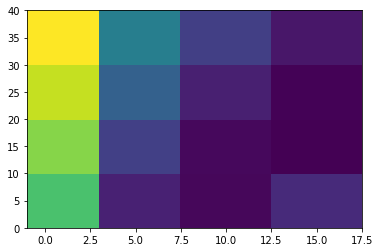

In [48]:
# Pick best solution

i, j = np.where(grid_range == grid_range.min())
percentile = percentile_range[int(i)]
size = size_range[int(j)]
print("Optimal percentile = {}, size = {}".format(percentile, size))

plt.pcolor(percentile_range, size_range, grid_range, shading='auto', )

In [49]:
def fill_ndimage(data,invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid')
    by the value of the nearest valid data cell
    """
    from scipy.ndimage import distance_transform_edt
    masked_array = hasattr(data, "fill_value")
    if masked_array:
        mask_fill_value = data.data == data.fill_value
        data = data.data.copy()
        data[mask_fill_value] = np.nan
    else:
        data = data.copy()

    if invalid is None:
        invalid = np.isnan(data)
        if masked_array:
            invalid += mask_fill_value
    ind = distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

# set up water table interpolators
wt_interp = RegularGridInterpolator((wt_ycoords, wt_xcoords), fill_ndimage(wt_data), bounds_error=False)
wt_interp_nan = RegularGridInterpolator((wt_ycoords, wt_xcoords), wt_data.mask.astype(int),
                                        bounds_error=False, fill_value=1)

# interpolate water table to DEM grid
topo_xq, topo_yq = np.meshgrid(topo_xc, topo_yc)
topo_zq = wt_interp((topo_yq, topo_xq), method='linear')

# mask regions that are outside GAB
topo_zq_mask = wt_interp_nan((topo_yq, topo_xq), method='nearest')
topo_zq[topo_zq_mask==1] = np.nan


# place inside topo_data and smoooooth
elevation = topo_data.copy()
elevation[elevation < -10] = -10
elevation[~np.isnan(topo_zq)] = topo_zq[~np.isnan(topo_zq)]
smooth_elevation = ndimage.percentile_filter(elevation, percentile, size=size)
smooth_elevation = fill_ndimage(smooth_elevation) # no gaps

Text(0.5, 1.0, 'Diff')

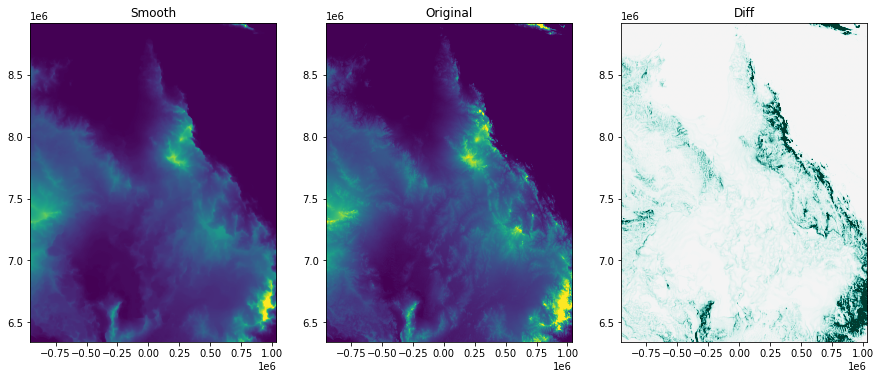

In [53]:
elevation_diff = elevation - smooth_elevation


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,15))

im1 = ax1.imshow(smooth_elevation, origin='lower', extent=topo_extent, vmin=-10, vmax=1000)
im2 = ax2.imshow(topo_data, origin='lower', extent=topo_extent, vmin=-10, vmax=1000)
im3 = ax3.imshow(elevation_diff, origin='lower', extent=topo_extent, cmap='BrBG', vmin=-200, vmax=200)

ax1.set_title('Smooth')
ax2.set_title('Original')
ax3.set_title("Diff")

In [54]:
# save water table

np.savez_compressed("../data/water_table_surface.npz",
                    data=elevation_diff,
                    x=topo_xc, y=topo_yc, extent=topo_extent)
